# HW 2 - Разложение матриц градиентным методом

Цель задания: В ходе реализации [разложения Таккера](https://proceedings.neurips.cc/paper/2018/file/45a766fa266ea2ebeb6680fa139d2a3d-Paper.pdf) градиентным методом освоить pyTorch и реализовать подходы оптимизации параметров модели (в отсутствии готовых решений).

[Более-менее внятное описание алгоритма канонического разложения](https://www.alexejgossmann.com/tensor_decomposition_tucker/) - само аналитическое разложение вам реализовывать НЕ НУЖНО

In [1]:
import random
import time
import torch
import pandas as pd
import numpy as np

import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from numpy.linalg import svd, matrix_rank, pinv, inv
from scipy.linalg import eigh, eig
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm
from torch import nn

torch.manual_seed(0)

In [2]:
!pip install tensorly

## 1 Создайте 3х мерный тензор
Размер тензора не меньше 100 по каждой из размерностей.

Заполните случайными целыми числами в диапазоне от 0 до 9.

Примечание: разложение будет корректно работать со случайным тензором, только если изначально создавать случайные ядро и матрицы, а потом по ним формировать тензор. Работайте с типом *torch.Tensor.double*.

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
def reorder(indices, mode):
    indices = list(indices)
    element = indices.pop(mode)
    return [element] + indices[::-1]

In [20]:
def fold(unfolded, mode, shape):
    unfolded_indicies = reorder(range(len(shape)), mode)
    original_shape = [shape[i] for i in unfolded_indicies]
    unfolded = unfolded.reshape(original_shape)
    
    folded_indices = list(range(len(shape) - 1, 0, -1))
    folded_indices.insert(mode, 0)
    return unfolded.permute(folded_indices)

In [21]:
def unfold(tensor, mode=0):
    return tensor.permute(reorder(range(tensor.ndim), mode)).reshape((tensor.shape[mode], -1))

In [22]:
def repair_tensor(G: torch.Tensor, U: torch.Tensor) -> torch.Tensor:
    data = G

    for index, u in enumerate(U):
        current_shape = data.shape
        unfolded_data = u @ unfold(data, index)
        shape = [current_shape[k] if k != index else u.shape[0] for k in range(len(current_shape))]
        data = fold(unfolded_data, index, shape)

    return data

In [23]:
# Создадим тензор: размер тензора и r задаётся
def get_tensor(size: tuple[int] = (100, 200, 150), rang: tuple[int] = (10, 10, 10)):
    # data - тензор с заданной размерностью
    # U - список матриц
    # G - ядро разложения
    G = torch.rand(r, device=device) * 9
    U = [torch.rand(size=(dim, rdim), device=device) for dim, rdim in zip(size, r)]
    data = repair_tensor(G, U)
    return data, U, G

Сгенерируйте тензор и добавьте к нему случайный шум с размерностью *1e-2*

In [24]:
size = (100, 200, 300)
r = (10, 10, 10)

data, U, G = get_tensor(size, r)
data.shape, [u.shape for u in U], G.shape

(torch.Size([100, 200, 300]),
 [torch.Size([100, 10]), torch.Size([200, 10]), torch.Size([300, 10])],
 torch.Size([10, 10, 10]))

In [25]:
def add_noise(tensor, device="cpu"):
    return tensor + 1e-2 * torch.normal(mean=torch.zeros_like(tensor)).to(device)

Вопрос:
Почему задание не имеет смысла для полностью случайного тензора и зачем добавлять шум? *не отвечать нельзя*

Ответ: потому что в случайном тензоре все вариации данных являются шумовыми. А не структурными, из-за чего любая попытка разложения может выделить искусственные компоненты, которые не имеют физического или практического смысла.

## 2 Реализуйте метод для восстановления тензора по разложению

Реализовал выше

## 3 Сделайте разложение библиотечным методом
Пакет можете брать любой

In [26]:
from tensorly.decomposition import tucker

Не забудьте померить ошибку разложения по метрике MSE

In [35]:
core, factors = tucker(data.cpu().detach().numpy(), (10, 10, 10))
core = torch.tensor(core)
factors = [torch.tensor(factor.copy()) for factor in factors]
data_repaired = repair_tensor(core, factors)

In [36]:
def MSE(target, predict):
    return torch.mean((target - predict) ** 2)

In [38]:
MSE(data_repaired, data.cpu()), MSE(core, G.cpu())

(tensor(7.9880e-08), tensor(2.1096e+09))

## 4 Реализуйте разложение градиентным методом

### 4.1 Реализуйте *optimizer*
Можно взять из исходников *PyTorch* и отнаследоваться от *torch.optim.optimizer*.
Используйте квадратичный *Loss*.

In [49]:
import math
import torch
from torch.optim.optimizer import Optimizer


class Opt(Optimizer):

    def __init__(self, params, lr=1e-3):
        self.lr = lr
        defaults = dict(lr=self.lr)
        super().__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if torch.isnan(grad).any() or torch.isinf(grad).any():
                    continue
                p.data.add_(-group['lr'], grad)

        return loss

### 4.2 Реализуйте цикл оптимизации параметров

Стоит параметры оптимизировать сразу на GPU

In [46]:
TENSOR_SIZE = (300, 200, 100)
RANKS = (10, 20, 30)

DATA_SIZE = 10
NUM_EPOCHS = 1000

## 5 Приведите сравнение скорости работы и ошибки восстановления методом из пакета и реализованного градиентного
Сравнение может считаться ± объективным с размером выборки от 10.

In [47]:
data = []
for i in range(DATA_SIZE):
    tensor, _, _ = get_tensor(TENSOR_SIZE, RANKS)
    data += [add_noise(tensor, DEVICE)]

In [51]:
loss_over_data = []
start_time = time.time()
for tensor in data:
    loss_history = []

    # Generating initial approximation
    kernel_approx = torch.rand(RANKS, requires_grad=True, device=DEVICE)
    factors_approx = [
        torch.rand(size=(dim, r_dim), requires_grad=True, device=DEVICE)
        for r_dim, dim in zip(RANKS, TENSOR_SIZE)
    ]
    optim = Opt(params=[kernel_approx] + factors_approx, lr=1e-05)

    for epoch in tqdm(range(NUM_EPOCHS)):
        optim.zero_grad()

        tensor_approx = repair_tensor(kernel_approx, factors_approx)
        loss = MSE(tensor, tensor_approx)
        loss.backward()

        loss_history += [loss]

        optim.step()

    loss_over_data += [loss_history]
end_time = time.time()
grad_mean_time = (end_time-start_time) / DATA_SIZE

  0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipykernel_123283/3637873678.py:26: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha = 1) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1642.)
  p.data.add_(-group['lr'], grad)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

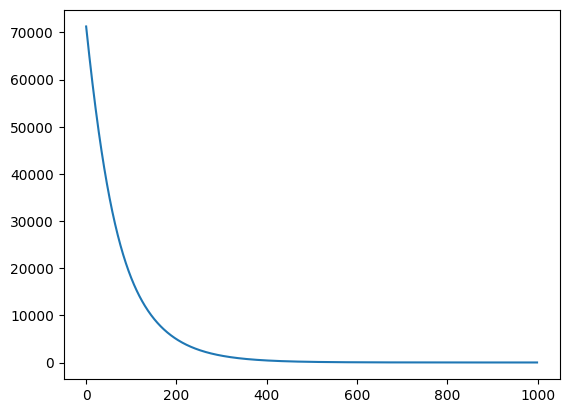

In [52]:
loss_values = [value.detach().to("cpu") for value in loss_over_data[0]]
plt.plot(loss_values)

In [54]:
total_time = 0
analitic_loss = []
for tensor in tqdm(data):
    tensor = tensor.to("cpu")
    start_time = time.time()
    core, factors = tucker(tensor.numpy(), RANKS)
    end_time = time.time()
    total_time += end_time-start_time
    
    core = torch.tensor(core)
    factors = [torch.tensor(factor.copy()) for factor in factors]
    tensor_rep = repair_tensor(core, factors)
    
    analitic_loss += [MSE(tensor_rep, tensor)]
analitic_mean_time = total_time / DATA_SIZE

  0%|          | 0/10 [00:00<?, ?it/s]

In [55]:
analitic_mean_loss = sum(analitic_loss) / DATA_SIZE
grad_mean_loss = torch.mean(torch.tensor([loss_over_data[i][-1] for i in range(DATA_SIZE)]))

In [56]:
print("Аналитическое решение", analitic_mean_time, "сек")
print("Градиентная оптимизация", grad_mean_time, "сек")

Аналитическое решение 1.0688865661621094 сек
Градиентная оптимизация 9.115954756736755 сек


In [57]:
print("MSE")
print("Аналитическое решение",   float(analitic_mean_loss))
print("Градиентная оптимизация", float(grad_mean_loss))

MSE
Аналитическое решение 9.967297955881804e-05
Градиентная оптимизация 35.389930725097656
